<a href="https://colab.research.google.com/github/muhammad-madridista/IntroductionToPytorch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
# Convert MNIST  Image files into a tensor of 4-Dimensions (# of images, Height, Width, Color Channels)
transform= transforms.ToTensor()

In [5]:
# Train Data
train_data= datasets.MNIST(root='../cnn_data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 91.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 52.7MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 56.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.56MB/s]


In [6]:
# Test Data
test_data= datasets.MNIST(root='../cnn_data', train=False, download=True, transform=transform)

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
pwd

'/content'

In [10]:
ls


sample_data/


In [11]:
cd ../


/


In [12]:
ls

bin@       datalab/  kaggle/  libx32@  proc/               run/   tmp/
boot/      dev/      lib@     media/   python-apt/         sbin@  tools/
cnn_data/  etc/      lib32@   mnt/     python-apt.tar.xz*  srv/   usr/
content/   home/     lib64@   opt/     root/               sys/   var/


In [13]:
cd cnn_data

/cnn_data


In [14]:
ls


MNIST/


In [15]:
cd ../


/


In [16]:
ls

bin@       datalab/  kaggle/  libx32@  proc/               run/   tmp/
boot/      dev/      lib@     media/   python-apt/         sbin@  tools/
cnn_data/  etc/      lib32@   mnt/     python-apt.tar.xz*  srv/   usr/
content/   home/     lib64@   opt/     root/               sys/   var/


In [17]:
cd content/

/content


In [18]:
# Create a small batch size for images let say 10
train_loader= DataLoader(train_data, batch_size=10, shuffle=True)
test_loader= DataLoader(test_data, batch_size=10, shuffle=False)


In [19]:
# Define Our CNN Model
# Describe convolutional layer and what its doing (2 convolutional layers)
conv1=nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2=nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

In [20]:
# Grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
  break

In [22]:
X_train.shape

torch.Size([1, 28, 28])

In [23]:
x=X_train.view(1,1,28,28)

In [24]:
# Perform our first convolution
x=F.relu(conv1(x)) # Rectified Linear Unit for our activation function

In [25]:
# 1 single image, 6 is the filters we asked for,26x26 the image size got shrinked because we didnt setup the padding
x.shape

torch.Size([1, 6, 26, 26])

In [26]:
# pass thru the pooling layer
x=F.max_pool2d(x, kernel_size=2, stride=2)


In [27]:
x.shape # 26/2= 13

torch.Size([1, 6, 13, 13])

In [28]:
# Do our second convolutional layer
x=F.relu(conv2(x))

In [29]:
x.shape # We didnt setup the padding so we lose 2 pixel around outside of the image to 11x11

torch.Size([1, 16, 11, 11])

In [30]:
# pooling layer
x=F.max_pool2d(x, kernel_size=2, stride=2)

In [31]:
x.shape # We have to round down because we cant invent the data to round up

torch.Size([1, 16, 5, 5])

In [37]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1,6,3,1)
    self.conv2=nn.Conv2d(6,16,3,1)

    # Fully Connected Layer
    self.fc1=nn.Linear(5*5*16,120)  # Corrected input features for fc1
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)  # Changed from fc1 to fc3

  def forward(self, X):
    X=F.relu(self.conv1(X))
    X=F.max_pool2d(X,2,2) # 2x2 kernal and stride of 2

    # Second Pass
    X=F.relu(self.conv2(X))
    X=F.max_pool2d(X,2,2) # 2x2 kernal and stride of 2

    # Review to flatten it out
    X=X.view(-1, 16*5*5)  # negative one so that we can vary the batch size

    # Fully Connected Layers
    X=F.relu(self.fc1(X))
    X=F.relu(self.fc2(X))
    X=self.fc3(X)
    return F.log_softmax(X, dim=1)

In [38]:
# Create an instance of our model
torch.manual_seed(41)
model= ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [34]:
# Loss Function Optimizer
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the learning rate, longer its gonna take


In [39]:
import time
start_time= time.time()

# Create Variables to track things
epochs=5
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

# Loop through the epochs
for i in range(epochs):
  trn_corr=0
  tst_corr=0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 # Start our batches at 1
    # Apply our model
    y_pred= model(X_train) # Get the predicted values from the training set. Not flattened 2D
    loss= criterion(y_pred,y_train) # how off are we Compare the predictions to correct answers in y_train

    predicted=torch.max(y_pred.data,1)[1] # Add up the number of correct predictions. Indexed off the first point
    batch_corr=(predicted==y_train).sum() # How many we got correct from this batch. True=1, False=0, sum those up
    trn_corr+= batch_corr # keep track as we go along the training

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print out some results
    if b%600==0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad(): # No gradient so we dont update our weights and biases with our test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val= model(X_test)
      predicted=torch.max(y_val.data,1)[1] #Adding up correct predictions
      tst_corr+=(predicted==y_test).sum() #T=1 F=0 and sum away


  loss= criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time= time.time()
total=current_time-start_time
print(f'Training Took: {total/60} minutes')

Epoch: 0 Batch: 600 Loss: 2.288074016571045
Epoch: 0 Batch: 1200 Loss: 2.2797932624816895
Epoch: 0 Batch: 1800 Loss: 2.2992568016052246
Epoch: 0 Batch: 2400 Loss: 2.2861452102661133
Epoch: 0 Batch: 3000 Loss: 2.29960298538208
Epoch: 0 Batch: 3600 Loss: 2.288022041320801
Epoch: 0 Batch: 4200 Loss: 2.304382801055908
Epoch: 0 Batch: 4800 Loss: 2.311393976211548
Epoch: 0 Batch: 5400 Loss: 2.280609607696533
Epoch: 0 Batch: 6000 Loss: 2.3415064811706543
Epoch: 1 Batch: 600 Loss: 2.32191801071167
Epoch: 1 Batch: 1200 Loss: 2.3383824825286865
Epoch: 1 Batch: 1800 Loss: 2.2785348892211914
Epoch: 1 Batch: 2400 Loss: 2.3208718299865723
Epoch: 1 Batch: 3000 Loss: 2.3262882232666016
Epoch: 1 Batch: 3600 Loss: 2.36456298828125
Epoch: 1 Batch: 4200 Loss: 2.3169384002685547
Epoch: 1 Batch: 4800 Loss: 2.301051616668701
Epoch: 1 Batch: 5400 Loss: 2.30649995803833
Epoch: 1 Batch: 6000 Loss: 2.299144983291626
Epoch: 2 Batch: 600 Loss: 2.2918381690979004
Epoch: 2 Batch: 1200 Loss: 2.311117649078369
Epoch: 

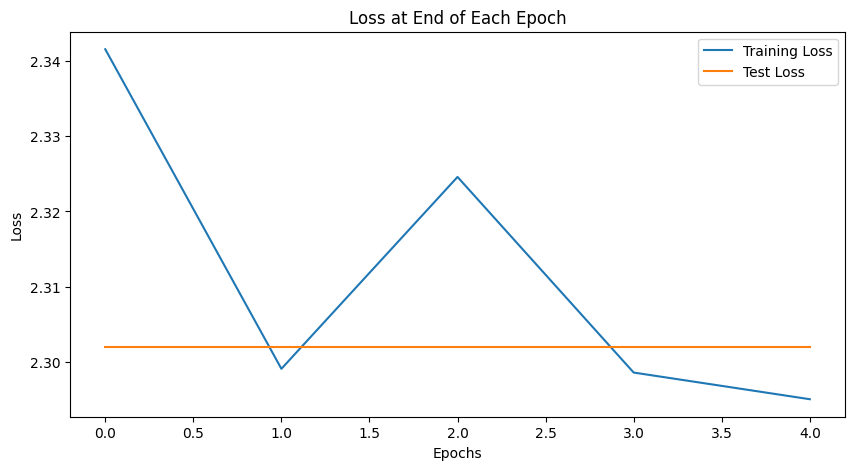

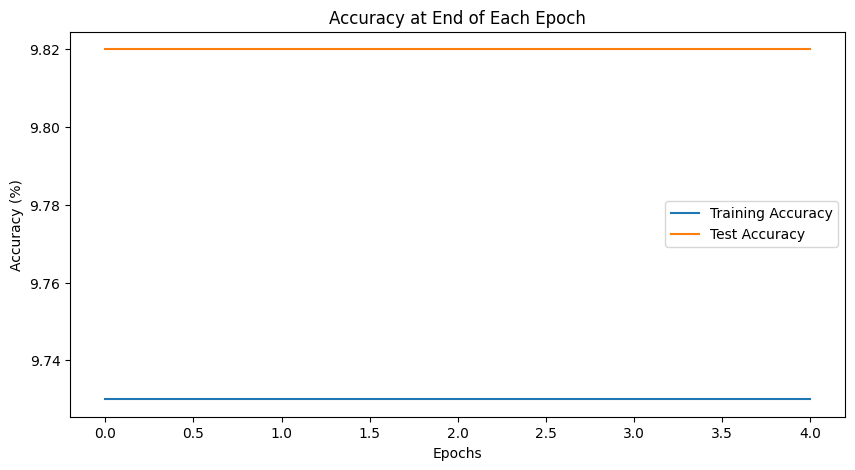

In [40]:
import matplotlib.pyplot as plt

# Convert losses and accuracies to numpy for plotting
train_losses_cpu = [t.item() for t in train_losses]
test_losses_cpu = [t.item() for t in test_losses]
train_correct_cpu = [t.item() for t in train_correct]
test_correct_cpu = [t.item() for t in test_correct]

# Calculate accuracy percentages
train_acc = [t / 60000 * 100 for t in train_correct_cpu]
test_acc = [t / 10000 * 100 for t in test_correct_cpu]

# Plotting losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses_cpu, label='Training Loss')
plt.plot(test_losses_cpu, label='Test Loss')
plt.title('Loss at End of Each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy at End of Each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [41]:
test_load_everything=DataLoader(test_data, batch_size=10000, shuffle=False)


In [42]:
with torch.no_grad():
  correct=0
  for b, (X_test, y_test) in enumerate(test_load_everything):
    y_val= model(X_test)
    predicted=torch.max(y_val,1)[1]
    correct+=(predicted==y_test).sum()
  print(f'Test Accuracy: {correct.item()/10000}')

Test Accuracy: 0.0982


In [51]:
# Grab an image
test_data[1978] # Tensor with an image in it  at end, it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [52]:
# Grab just the data
test_data[1978][0]


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [53]:
# Reshape it
test_data[1978][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

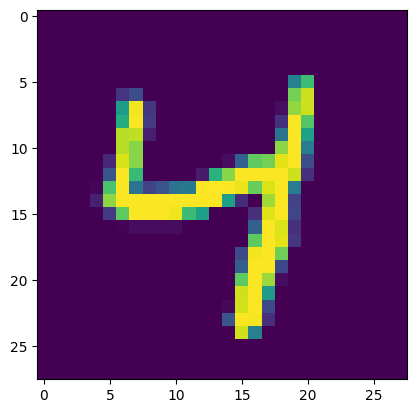

In [54]:
# Show the image
plt.imshow(test_data[1978][0].reshape(28,28))

In [55]:
# Pass the image through our Model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1978][0].view(1,1,28,28))


In [56]:
new_prediction.argmax()

tensor(4)